# Visualize feature maps of YOLOv4  
code by [karb0n](https://github.com/CSY-tvgo)  
## Import packages and declare functions

In [4]:
# coding:utf-8

import time
import os
import numpy as np
import cv2
from yolo import tools
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.python.platform import gfile
import matplotlib
import matplotlib.pyplot as plt
import random
import threading

ConfigProto000 = ConfigProto()
ConfigProto000.gpu_options.allow_growth = True
session = InteractiveSession(config=ConfigProto000)

def read_img(img_name, width, height):
    img_ori = tools.read_img(img_name)
    if img_ori is None:
        return None, None
    img = cv2.resize(img_ori, (width, height))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    img = img / 255.0 
    img = np.expand_dims(img, 0)
    return img, img_ori


def capture_frame(webcam, width, height):
    ok, img_ori = webcam.read()
    if not ok:
        return None, None
    img = cv2.resize(img_ori, (width, height))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    img = img/255.0
    img = np.expand_dims(img, 0)
    return img, img_ori


def draw_on_canvas(canvas, content, x, y):
    canvas = canvas.copy()
    content_height, content_width = content.shape[0: 2]
    canvas[y: y+content_height, x: x+content_width] = content.copy()
    return canvas


def putText_on_canvas(canvas, content, x, y, size=0.2, color=(0, 0, 0), thickness=1, lineInterval=20):
    canvas = canvas.copy()
    lines = content.split('\n')
    for i in range(len(lines)):
        canvas = cv2.putText(
            canvas, lines[i], (x, y+i*lineInterval), cv2.FONT_HERSHEY_TRIPLEX, size, color, thickness)
    return canvas


def fake_color(gray_img):
    mu = gray_img.max() - gray_img.min()
    gray_img = (((gray_img.copy() - gray_img.min()) / mu) * 255).astype('uint8')
    color_img = cv2.applyColorMap(gray_img, cv2.COLORMAP_JET)
    return color_img

## Load model and init graph 

In [5]:
sess = tf.Session()

# your pb_model path
pb_dir = "./yolo/yolov4_coco.pb"  # You can download "yolov4_coco.pb" on (https://www.dropbox.com/s/h1n5n87wvczlw6v/yolov4_coco.pb?dl=0)
# your class_num
class_num = 80
# your names file
names_file = "./yolo/coco.names"

with gfile.FastGFile(pb_dir, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name="")
sess.run(tf.global_variables_initializer())

# inputs
inputs = sess.graph.get_tensor_by_name('Placeholder:0')
# output
# 'concat_9', 'concat_10', 'concat_11'
pre_boxes = sess.graph.get_tensor_by_name('concat_9:0')
pre_score = sess.graph.get_tensor_by_name('concat_10:0')
pre_label = sess.graph.get_tensor_by_name('concat_11:0')

width, height = 608, 608

word_dict = tools.get_word_dict(names_file)        # for COCO
color_table = tools.get_color_table(class_num)

Instructions for updating:
Use tf.gfile.GFile.


## Choose feature maps you want to visualize

In [6]:
# choose tensors
tensor_names = ["Downsample/Conv/Conv2D:0",
                "Downsample/Pad:0",
                "Downsample/Conv_1/mul:0",
                "Downsample/concat:0",
                "Downsample/Conv_8/mul:0",
                "Downsample/concat_1:0",
                "Downsample/Conv_17/mul:0",
                "Downsample/Conv_18/BatchNorm/FusedBatchNormV3:0",
                "Downsample/concat_2:0",
                "Downsample/Conv_39/BatchNorm/FusedBatchNormV3:0",
                "Downsample/Conv_59/mul:0",
                "Downsample/Conv_60/BatchNorm/FusedBatchNormV3:0",
                "leaky_relu/concat:0",
                "leaky_relu/Conv_5/LeakyRelu:0",  # F1
                "yolo/Conv_9/BiasAdd:0",          # F2
                "yolo/Conv_17/BiasAdd:0"]         # F3               

tensors = []
for n in tensor_names:
    tensors.append(sess.graph.get_tensor_by_name(n))
    
feature_maps = [None]*len(tensors)

## Test on one image  
### Detect and draw boxes  

In [12]:
img_name = './test_img/dog.jpg'

start = time.perf_counter()

img, img_ori = read_img(img_name, width, height)

boxes, score, label, feature_maps = sess.run(
    [pre_boxes, pre_score, pre_label, tensors], feed_dict={inputs: img})

end = time.perf_counter()
print("Detection time: %f s" % (end-start))

img_ori = tools.draw_img(
    img_ori, boxes, score, label, word_dict, color_table)

print("\nTensors shape: \t\t Tensors name:")
for i in range(len(tensor_names)):
    print(feature_maps[i].shape, '\t',tensor_names[i])

Detection time: 0.197265 s

Tensors shape: 		 Tensors name:
(1, 608, 608, 32) 	 Downsample/Conv/Conv2D:0
(1, 610, 610, 32) 	 Downsample/Pad:0
(1, 304, 304, 64) 	 Downsample/Conv_1/mul:0
(1, 304, 304, 128) 	 Downsample/concat:0
(1, 152, 152, 128) 	 Downsample/Conv_8/mul:0
(1, 152, 152, 128) 	 Downsample/concat_1:0
(1, 76, 76, 256) 	 Downsample/Conv_17/mul:0
(1, 76, 76, 128) 	 Downsample/Conv_18/BatchNorm/FusedBatchNormV3:0
(1, 76, 76, 256) 	 Downsample/concat_2:0
(1, 38, 38, 256) 	 Downsample/Conv_39/BatchNorm/FusedBatchNormV3:0
(1, 19, 19, 1024) 	 Downsample/Conv_59/mul:0
(1, 19, 19, 512) 	 Downsample/Conv_60/BatchNorm/FusedBatchNormV3:0
(1, 19, 19, 2048) 	 leaky_relu/concat:0
(1, 19, 19, 512) 	 leaky_relu/Conv_5/LeakyRelu:0
(1, 38, 38, 255) 	 yolo/Conv_9/BiasAdd:0
(1, 19, 19, 255) 	 yolo/Conv_17/BiasAdd:0


### Visualize feature maps
##### Single-thread drawing consumes ~1.553997 s @(i7-6700HQ with GTX1060)

Draw: 1.481425 s


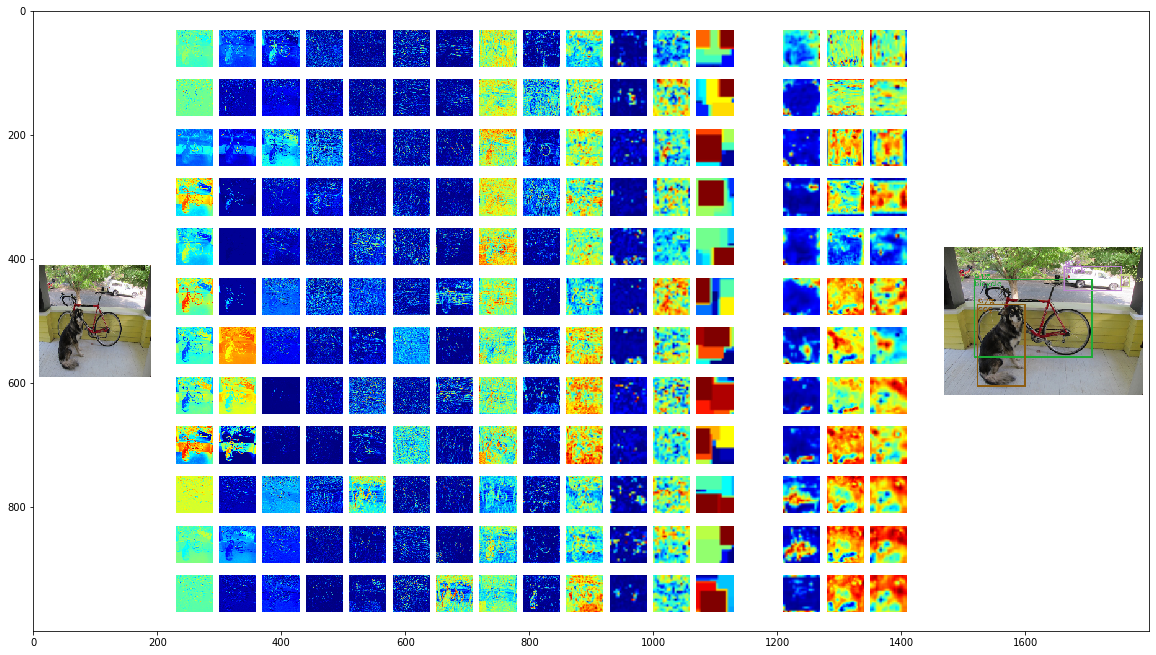

In [14]:
start = time.perf_counter()

feature_map_canvas = np.zeros([1000, 1800, 3], dtype='uint8') + 255

feature_map_canvas = draw_on_canvas(feature_map_canvas, cv2.cvtColor(cv2.resize(img[0], (180, 180)), cv2.COLOR_RGB2BGR)*255, 10, 410)

fmnum = 0 # 从同一个 tensor 中的第几个 feature map 开始显示

for i in range(len(tensor_names)):
    thisTensor = feature_maps[i]
    for j in range(12):
        content = thisTensor[0, :, :, j+fmnum]
        content = fake_color(content)
        content = cv2.resize(content, (60, 60))
        if i < len(tensor_names) - 3:
            feature_map_canvas = draw_on_canvas(feature_map_canvas, content, 230+i*70, 30+j*80)
        else:
            feature_map_canvas = draw_on_canvas(feature_map_canvas, content, 300+i*70, 30+j*80)
        
feature_map_canvas = draw_on_canvas(feature_map_canvas, cv2.resize(img_ori, (320, 240)), 1470, 380)

end = time.perf_counter()

print("Draw: %f s" % (end - start))

plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(feature_map_canvas, cv2.COLOR_BGR2RGB))

##### Multi-thread drawing consumes ~0.472459 s @(i7-6700HQ with GTX1060)

Draw: 0.461704 s


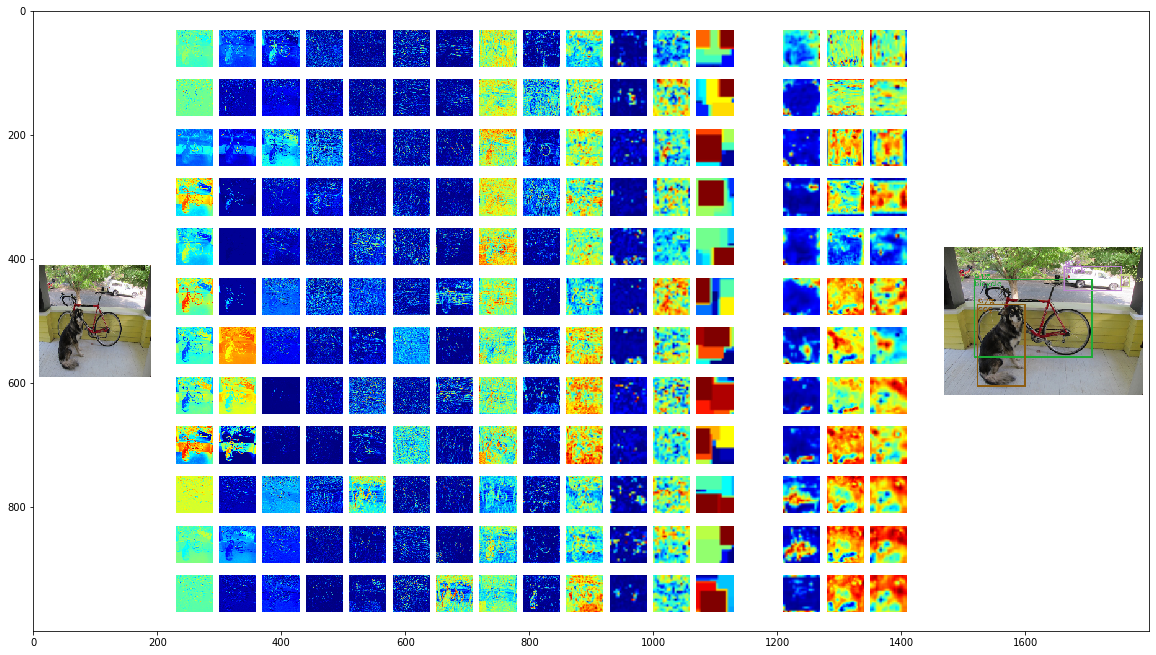

In [15]:
start = time.perf_counter()

feature_map_canvas = np.zeros([1000, 1800, 3], dtype='uint8') + 255
parts = np.zeros([16, 940, 60, 3], dtype='uint8') + 255

feature_map_canvas = draw_on_canvas(feature_map_canvas, cv2.cvtColor(cv2.resize(img[0], (180, 180)), cv2.COLOR_RGB2BGR)*255, 10, 410)


fmnum = 0

def draw_part(i):
    thisTensor = feature_maps[i]
    for j in range(12):
        content = thisTensor[0, :, :, j+fmnum]
        content = fake_color(content)
        content = cv2.resize(content, (60, 60))
        parts[i] = draw_on_canvas(parts[i], content, 0, j*80)
    return

threads = []
for i in range(16):
    t = threading.Thread(target=draw_part,args=(i,))
    t.start()
    threads.append(t)
        
for t in threads:
    t.join()

for i in range(16):
    if i < len(tensor_names) - 3:
        feature_map_canvas = draw_on_canvas(feature_map_canvas, parts[i], 230+i*70, 30)
    else:
        feature_map_canvas = draw_on_canvas(feature_map_canvas, parts[i], 300+i*70, 30)

feature_map_canvas = draw_on_canvas(feature_map_canvas, cv2.resize(img_ori, (320, 240)), 1470, 380)

end = time.perf_counter()

print("Draw: %f s" % (end - start))

plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(feature_map_canvas, cv2.COLOR_BGR2RGB))

## Use webcam

In [16]:
webcam = cv2.VideoCapture(0)

while True:
    t0 = time.perf_counter()

    frame, frame_ori = capture_frame(webcam, width, height)
    if frame is None:
        cv2.destroyAllWindows()
        webcam.release()
        break

    boxes, score, label, feature_maps = sess.run(
        [pre_boxes, pre_score, pre_label, tensors], feed_dict={inputs: frame})

    frame_ori = tools.draw_img(
        frame_ori, boxes, score, label, word_dict, color_table)

    t1 = time.perf_counter()

    canvas = np.zeros(
        [1000, 1800, 3], dtype='uint8') + 255 
    parts = np.zeros([16, 940, 60, 3], dtype='uint8') + 255

    canvas = draw_on_canvas(canvas, cv2.cvtColor(
        cv2.resize(frame[0], (180, 180)), cv2.COLOR_RGB2BGR)*255, 10, 410)

    fmnum = 0

    def draw_part(i): 
        thisTensor = feature_maps[i]
        for j in range(12):
            content = thisTensor[0, :, :, j+fmnum]
            content = fake_color(content)
            content = cv2.resize(content, (60, 60))
            parts[i] = draw_on_canvas(parts[i], content, 0, j*80)
        return

    threads = []
    for i in range(16):
        t = threading.Thread(target=draw_part, args=(i,))
        t.start()
        threads.append(t)
    for t in threads:
        t.join()

    for i in range(16):
        if i < len(tensor_names) - 3:
            canvas = draw_on_canvas(canvas, parts[i], 230+i*70, 30)
        else:
            canvas = draw_on_canvas(canvas, parts[i], 300+i*70, 30)

    canvas = draw_on_canvas(canvas, cv2.resize(frame_ori, (320, 240)), 1470, 380)

    t2 = time.perf_counter()

    consumeTime = "Detect: %f s, Draw: %f s, Total: %f s" % (
        t1-t0, t2-t1, t2-t0)
    print("\r" + consumeTime, end=" ")
    canvas = putText_on_canvas(canvas, consumeTime.replace(',', '\n'),
                               1450, 700, size=1, lineInterval=40)

    cv2.namedWindow("YOLOv4")
    cv2.imshow("YOLOv4", cv2.resize(canvas, (1440, 800)))

    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        webcam.release()
        break

Detect: 0.180525 s, Draw: 0.452258 s, Total: 0.632783 s 